## 累计与分组
- 在对较大的数据进行分析时，一项基本的工作就是有效的数据累计（summarization）：计算累计（aggregation）指标，如sum()、mean()、median()、min()和max()，其中每一个指标都呈现了大数据集的特征。在这一节中，我们将探索Pandas的累计功能，从类似前面NumPy数组中的简单操作，到基于groupby实现的复杂操作。

#### Pandas的简单累计功能

In [1]:
import pandas as pd
import numpy as np
rng = np.random.RandomState(42)
ser = pd.Series(rng.rand(5))
ser

0    0.374540
1    0.950714
2    0.731994
3    0.598658
4    0.156019
dtype: float64

In [2]:
ser.sum()

2.811925491708157

In [3]:
ser.mean()

0.5623850983416314

- DataFrame 的累计函数默认对每列进行统计

In [5]:
df = pd.DataFrame({"A":rng.rand(5),"B":rng.rand(5)})
df

,A,B
0,0.155995,0.020584
1,0.058084,0.969910
2,0.866176,0.832443
3,0.601115,0.212339
4,0.708073,0.181825


In [6]:
df.mean()

A    0.477888
B    0.443420
dtype: float64

In [13]:
# 设置axis参数，你就可以对每一行进行统计了：
df.mean(axis=1)

0    0.088290
1    0.513997
2    0.849309
3    0.406727
4    0.444949
dtype: float64

In [15]:
# pandas 的 dexcribe 方法可以计算每一列的若干常用统计值
print(df)
df_desc = df.describe()
print()
print(df_desc)

          A         B
0  0.155995  0.020584
1  0.058084  0.969910
2  0.866176  0.832443
3  0.601115  0.212339
4  0.708073  0.181825

              A         B
count  5.000000  5.000000
mean   0.477888  0.443420
std    0.353125  0.426952
min    0.058084  0.020584
25%    0.155995  0.181825
50%    0.601115  0.212339
75%    0.708073  0.832443
max    0.866176  0.969910


#### 指标解析
    指标                    描述
    count()                 计数项
    first(),last()          第一项与最后一项
    mean(),median()         均值与中位数 
    std(),var()             标准差与方差 
    min(),max()             最小值与最大值
    mad()                   均值绝对偏差
    prod()                  所有项乘积
    sum()                   所有项求和
- DataFrame和Series对象支持以上所有方法。

# GroupBy：分割、应用和组合

    简单的累计方法可以让我们对数据集有一个笼统的认识，但是我们经常还需要对某些标签或索引的局部进行累计分析，这时就需要用到groupby了。虽然“分组”（group by）这个名字是借用SQL数据库语言的命令，但其理念引用发明R语言frame的Hadley Wickham的观点可能更合适：分割（split）、应用（apply）和组合（combine）。
    
- 分割步骤将DataFrame按照指定的键分割成若干组。

- 应用步骤对每个组应用函数，通常是累计、转换或过滤函数。

- 组合步骤将每一组的结果合并成一个输出数组

#### groupby操作的可视化过程
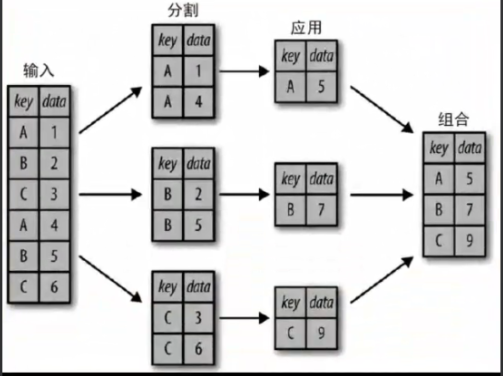

In [16]:
import pandas as pd
import numpy as np
df = pd.DataFrame({'key':['A','B','C','A','B','C'],
                  'data':range(6)},columns=['key','data'])
df

,key,data
0,A,0
1,B,1
2,C,2
3,A,3
4,B,4
5,C,5


In [17]:
# 我们可以用DataFrame的groupby()方法进行绝大多数常见的分割-应用-组合操作，将需要分组的列名传进去即可：

df.groupby('key')

需要注意的是，这里的返回值不是一个DataFrame对象，而是一个DataFrameGroupBy对象。这个对象的魔力在于，你可以将它看成是一种特殊形式的DataFrame，里面隐藏着若干组数据，但是在没有应用累计函数之前不会计算。这种“延迟计算”（lazy evaluation）的方法使得大多数常见的累计操作可以通过一种对用户而言几乎是透明的（感觉操作仿佛不存在）方式非常高效地实现。

In [22]:
# 得到结果,可以对DataFrameGroupBy对象应用累计函数，他会完成相应的应用/组合步骤并生成结果
df.groupby('key').sum()


,data
key,
A,3
B,5
C,7


## GroupBy对象
- GroupBy对象是一种非常灵活的抽象类型。在大多数场景中，你可以将它看成是DataFrame的集合，在底层解决所有难题。
    GroupBy中最重要的操作可能就是aggregate、filter、transform和apply（累计、过滤、转换、应用）了，后文将详细介绍这些内容，现在先来介绍一些GroupBy的基本操作方法。
    
#### 1. 按列取值。
- GroupBy对象与DataFrame一样，也支持按列取值，并返回一个修改过的GroupBy对象

#### 2. 按组迭代。
- GroupBy对象支持直接按组进行迭代，返回的每一组都是Series或DataFrame：

#### 3. 调用方法。
- 借助Python类的魔力（@classmethod），可以让任何不由GroupBy对象直接实现的方法直接应用到每一组，无论是DataFrame还是Series对象都同样适用。例如，你可以用DataFrame的describe()方法进行累计，对每一组数据进行描述性统计：

In [25]:
df.groupby('key').median()

,data
key,
A,1.5
B,2.5
C,3.5


In [27]:
df.groupby('key').describe()

data1                                          data2                      \
    count mean      std  min   25%  50%   75%  max count mean       std  min   
key                                                                            
A     2.0  1.5  2.12132  0.0  0.75  1.5  2.25  3.0   2.0  4.5  0.707107  4.0   
B     2.0  2.5  2.12132  1.0  1.75  2.5  3.25  4.0   2.0  4.0  5.656854  0.0   
C     2.0  3.5  2.12132  2.0  2.75  3.5  4.25  5.0   2.0  4.5  6.363961  0.0   

                           
      25%  50%   75%  max  
key                        
A    4.25  4.5  4.75  5.0  
B    2.00  4.0  6.00  8.0  
C    2.25  4.5  6.75  9.0

In [28]:
ng = np.random.RandomState(0)
df = pd.DataFrame({'key': ['A', 'B', 'C', 'A', 'B', 'C'],
                   'data1': range(6),
                   'data2': rng.randint(0, 10, 6)},
                   columns = ['key', 'data1', 'data2'])
df

,key,data1,data2
0,A,0,9
1,B,1,2
2,C,2,6
3,A,3,3
4,B,4,8
5,C,5,2


#### 累计。
- 我们目前比较熟悉的GroupBy累计方法只有sum()和median()之类的简单函数，但是aggregate()其实可以支持更复杂的操作，比如字符串、函数或者函数列表，并且能一次性计算所有累计值

In [29]:
import pandas as pd
import numpy as np
df.groupby('key').aggregate(['min',np.median,max])

data1            data2           
      min median max   min median max
key                                  
A       0    1.5   3     3      6   9
B       1    2.5   4     2      5   8
C       2    3.5   5     2      4   6

In [31]:
# 另一种用法就是通过Python字典指定不同列需要累计的函数：
df.groupby('key').aggregate({'data1': 'min',
                            'data2': 'max'})

,data1,data2
key,,
A,0,9
B,1,8
C,2,6


3.141592653589793
27182818284.59045
0.6666666666666666
